

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 7 - Generative Models - Autoencoders and GANs 



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Pavlos Protopapas and Mark Glickman 


<hr style="height:2pt">

### INSTRUCTIONS

- This is individual homework - No collaboration/Groups
- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit (excluding large networks)
- Please note that the model training in this assignment can take a long time (even on a GPU). Expect to train for more than 2-3hrs per model.

<hr style="height:2pt">

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [4]:
#PLEASE RUN THIS CELL 
import requests
import glob, cv2, os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

from skimage.io import imread
from scipy.misc import imresize
from scipy.stats import norm
from sklearn.model_selection import train_test_split


from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization
from keras.layers import *
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras.preprocessing.image import ImageDataGenerator
import random
import utils


from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Question 1: Making Faces [97 pts]  </b></div>

We'll be using a subset of the Celeb A dataset to help us build facial generative models, as described on the [Celeb A](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) website. CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. 

CelebA has large diversities, large quantities, and rich annotations, including

- 10,177 number of identities,
- 202,599 number of face images, 
- 5 landmark locations, and 
- 40 binary attributes annotations per image.

### Part A:  Preparing the Data [10 pts]

**1.A.1.** Download the dataset from: [CelebA Dataset](https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/celeba-dataset.zip). In the provided data you'll see the `img_align_celeba` directory. The images in that directory will form your dataset.  You may want to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).  

**1.A.2.** Load the attribute data in `list_attr_celeba.csv` into a pandas dataframe.

**1.A.3.** Pick 3 random images from the dataset, plot them, and verify that the attributes are accurate.

## Solution: Part A

In [15]:
def img_preprocess(img, output_shape=(176,216)):
    resize = output_shape
    reshape = (-1,)+resize+(3,)
    img = cv2.resize(img, resize) / 255.0
    img = img.reshape(reshape) 
    return(img)

### 1.A.2.

In [16]:
attr = pd.read_csv('data/list_attr_celeba.csv').reset_index()
attr_cols = list(set(attr.columns)^set(['image_id']))

# Sub-sample for faster training
rand_rows = np.random.choice(np.array(attr.index), 30000)
attr_train_sample = attr[attr.index.isin(rand_rows)].reset_index()
df_gen = attr
attr_train_sample.shape

(27878, 43)

### 1.A.1.

In [7]:
# # Unzip data sets
# ! unzip data/celeba-dataset.zip
# ! unzip img_align_celeba.zip

In [8]:
img_dir = 'data/img_align_celeba'

In [9]:
orig_image_shape = imread(img_dir+'/'+'000001.jpg').shape
#target_size_gen = orig_image_shape[:2]
target_size_gen = (216,176)

In [10]:
batch = 32

datagen = ImageDataGenerator(rescale=1./255, 
                             validation_split=0.25)

train_generator = datagen.flow_from_dataframe(
    dataframe=df_gen, directory=img_dir, 
    x_col='image_id', y_col=attr_cols,
    subset="training",
    target_size=target_size_gen,
    seed=42, shuffle=True, 
    class_mode='input', 
    batch_size=batch
    )

val_generator = datagen.flow_from_dataframe(
    dataframe=df_gen, directory=img_dir, 
    x_col='image_id', y_col=attr_cols,
    subset="validation",
    target_size=target_size_gen,
    seed=42, shuffle=True, 
    class_mode='input', 
    batch_size=batch,
    )

Found 151950 images.
Found 50649 images.


In [11]:
display(train_generator.image_shape)
display(val_generator.image_shape)

(216, 176, 3)

(216, 176, 3)

### 1.A.3.

In [12]:
rand_img = np.random.choice(attr['image_id'], 3)

         index    image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
200544  200544  200545.jpg                -1               -1          -1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  ...    Sideburns  \
200544               -1     1     -1         1         1  ...           -1   

        Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  \
200544        1             -1         -1                -1           -1   

        Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  Young  
200544                -1                -1                1     -1  

[1 rows x 42 columns]
         index    image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
190913  190913  190914.jpg                -1               -1          -1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  ...    Sideburns  \
190913               -1    -1     -1        -1        -1  ...           -1   

        Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  W

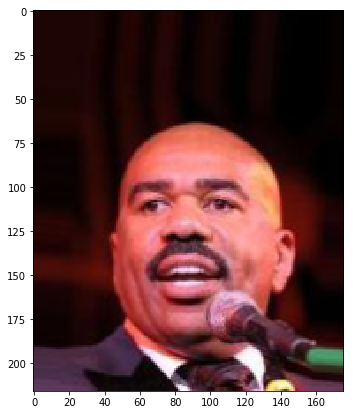

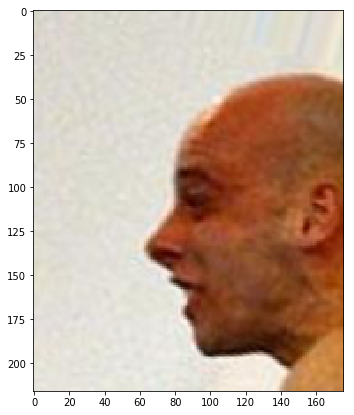

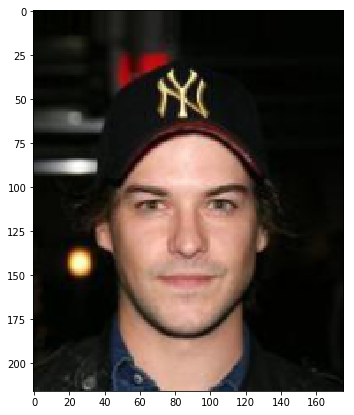

In [14]:
for i in rand_img:
    plt.figure(figsize=(20,7))
    img = imread(img_dir+'/'+i)
    img = cv2.resize(img, (176,216)) / 255.0
    plt.imshow(img, cmap='gray')
    print(attr[attr['image_id']==i])

### Part B: Building and Training a Variational Autoencoder Model [44 pts]

**1.B.1.** Create and compile a Convolutional Variational Autoencoder Model (including encoder and decoder) for the celebrity faces dataset.  Print summaries for the encoder, decoder and full autoencoder models.

**1.B.2.** Train your model on the images in the celebA dataset.

**1.B.3.** Choose a random input image.  Encode the image and then Decode the latent representation.  Plot the original image and the reconstructed output.  How do they compare?

**1.B.4.** Choose two celebrity faces from the dataset that differ according to two attributes and taking advantages of alterations of the latent representations image morph from one to the other.  See below for an example.

![](latent_1.png)

**1.B.5.** Generate and visualise around 15 celebrity faces not in your training set.  How do the generated faces compare in quality to celebrity faces from the training samples?

#### Please note that the VAE model can take a long time to train before you obtain decent results. Expect to train for more than 2-3hrs depending on the batch size

## Solution: Part B

In [12]:
# store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# load model 
def load_keras_model(model_name, custom_objs: dict):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json, custom_objects=custom_objs)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

In [13]:
def add_encoder_block(inp, filters, filter_size, model):
    if model == 'dcgan':
        x = Conv2D(filters, filter_size, padding='same')(inp)
        x = BatchNormalization()(x)
        x = Conv2D(filters, filter_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.3)(x)
    elif model == 'vae': 
        x = Conv2D(filters, filter_size, padding='same', activation='relu')(inp)
        x = BatchNormalization(axis=2)(x)
        x = Conv2D(filters, filter_size, padding='same', activation='relu')(x)
        x = MaxPool2D()(x)
    return x

def add_decoder_block(inp, filters, filter_size, model):
    if model == 'dcgan':
        x = Conv2D(filters, filter_size, padding='same')(inp)
        x = BatchNormalization()(x)
        x = Conv2D(filters, filter_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.3)(x)
    elif model == 'vae': 
        x = UpSampling2D()(inp)
        x = Conv2DTranspose(filters, filter_size, padding='same', activation='relu')(x)
        x = BatchNormalization(axis=2)(x)
        x = Conv2DTranspose(filters, filter_size, padding='same', activation='relu')(x)
    return x

In [18]:
def build_vae(image_shape, latent_dim, n_filters):
   
    ##### ENCODER MODEL #####
    
    input_layer = Input(shape=image_shape)

    x = add_encoder_block(input_layer, n_filters * 4, 3, model='vae')
    x = add_encoder_block(x, n_filters * 2, 3, model='vae')
    x = add_encoder_block(x, n_filters, 3, model='vae')

    # shape of the network for decoder
    shape_before_flattening = K.int_shape(x)

    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)

    # Z - Mu and Sigma
    z_mu = Dense(latent_dim)(x)
    z_log_sigma = Dense(latent_dim)(x)
    
    # Sampling
    def sampling(args):
        z_mu, z_log_sigma = args
        epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim), mean=0., stddev=1.)
        return(z_mu + K.exp(z_log_sigma) * epsilon)

    # sample vector from the latent distribution
    z = Lambda(sampling)([z_mu, z_log_sigma])
    
    # instantiate encoder model
    encoder = Model(input_layer, [z_mu, z_log_sigma, z], name='encoder')
    encoder.summary()
    
    ##### DECODER MODEL #####
    
    # decoder takes the latent distribution sample as input
    decoder_input = Input(K.int_shape(z)[1:])

    x = Dense(np.prod(shape_before_flattening[1:]),
                     activation='relu')(decoder_input)

    # reshape
    x = Reshape(shape_before_flattening[1:])(x)

   # use Conv2DTranspose to reverse the conv layers from the encoder
    x = add_decoder_block(x, n_filters * 4, 3, model='vae')
    x = add_decoder_block(x, n_filters * 2, 3, model='vae')
    x = add_decoder_block(x, n_filters, 3, model='vae')
    x = Conv2D(3, 3, padding='same', activation='sigmoid')(x)
    
    # instantiate decoder model
    decoder = Model(decoder_input, x)
    decoder.summary()
    
    
    def vae_loss(input_layer, output_layer):
        inputs = K.flatten(input_layer)
        outputs = K.flatten(output_layer)
        # Reconstruction loss
        xent_loss = mse(inputs, outputs)
        xent_loss = K.mean(xent_loss)
        # KL divergence
        kl_loss = -0.0001 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    # instantiate VAE model
    output_layer = decoder(encoder(input_layer)[2])
    vae = Model(input_layer, output_layer)
    vae.compile(optimizer='rmsprop', loss=vae_loss)
    vae.summary()
    
    
    return(vae, encoder, decoder)

### 1.B.1.

In [19]:
image_shape = train_generator.image_shape
latent_dim = 2
n_filters = 8

In [20]:
vae, encoder, decoder = build_vae(image_shape=image_shape, latent_dim=latent_dim, n_filters=n_filters)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 216, 176, 3)  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 216, 176, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 216, 176, 32) 704         conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 216, 176, 32) 9248        batch_normalization_7[0][0]      
__________________________________________________________________________________________________
max_poolin

### 1.B.2.

In [21]:
step_train = int(train_generator.n//train_generator.batch_size)
step_val = int(val_generator.n//val_generator.batch_size)

history = vae.fit_generator(generator=train_generator,
                            steps_per_epoch=step_train,
                            validation_data=val_generator,
                            validation_steps=step_val,
                            epochs=7)

Epoch 1/7
4748/4748 [==============================] - 2598s 547ms/step - loss: 8.6113 - val_loss: 0.0468
Epoch 2/7
4748/4748 [==============================] - 2590s 545ms/step - loss: 0.0469 - val_loss: 0.0470
Epoch 3/7
4748/4748 [==============================] - 2591s 546ms/step - loss: 0.0463 - val_loss: 0.0508
Epoch 4/7
4748/4748 [==============================] - 2588s 545ms/step - loss: 0.0460 - val_loss: 0.0470
Epoch 5/7
4748/4748 [==============================] - 2591s 546ms/step - loss: 0.0458 - val_loss: 0.0457
Epoch 6/7
4748/4748 [==============================] - 2595s 546ms/step - loss: 0.0457 - val_loss: 0.0455
Epoch 7/7
4748/4748 [==============================] - 2592s 546ms/step - loss: 0.0456 - val_loss: 0.0462


In [222]:
store_keras_model(vae, 'model_vae')

Saved model to disk


### 1.B.3.

In [132]:
custom_objs = {'latent_dim': latent_dim}
vae = load_keras_model('model_vae',custom_objs=custom_objs)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 216, 176, 3)       0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 96180     
_________________________________________________________________
model_25 (Model)             (None, 216, 176, 3)       35979     
Total params: 132,159
Trainable params: 130,927
Non-trainable params: 1,232
_________________________________________________________________


In [143]:
encoder = vae.layers[1]
decoder = vae.layers[2]

In [144]:
n_images = 5
model = vae
generator = val_generator

def gen_pred_images(model, generator, n_images):
    rand_img = np.random.choice(generator.filenames, n_images)

    fig, ax = plt.subplots(n_images,2, figsize=(15,45))

    for i in range(n_images):
        img = imread(img_dir+'/'+rand_img[i])

        ax[i,0].imshow(img, cmap='gray')


        # resize to pass to vae
        img = img_preprocess(img, generator.image_shape[:2])

        # predict using vae
        pred = vae.predict(img)


        ax[i,1].imshow(pred[0])

    return(fig,ax)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


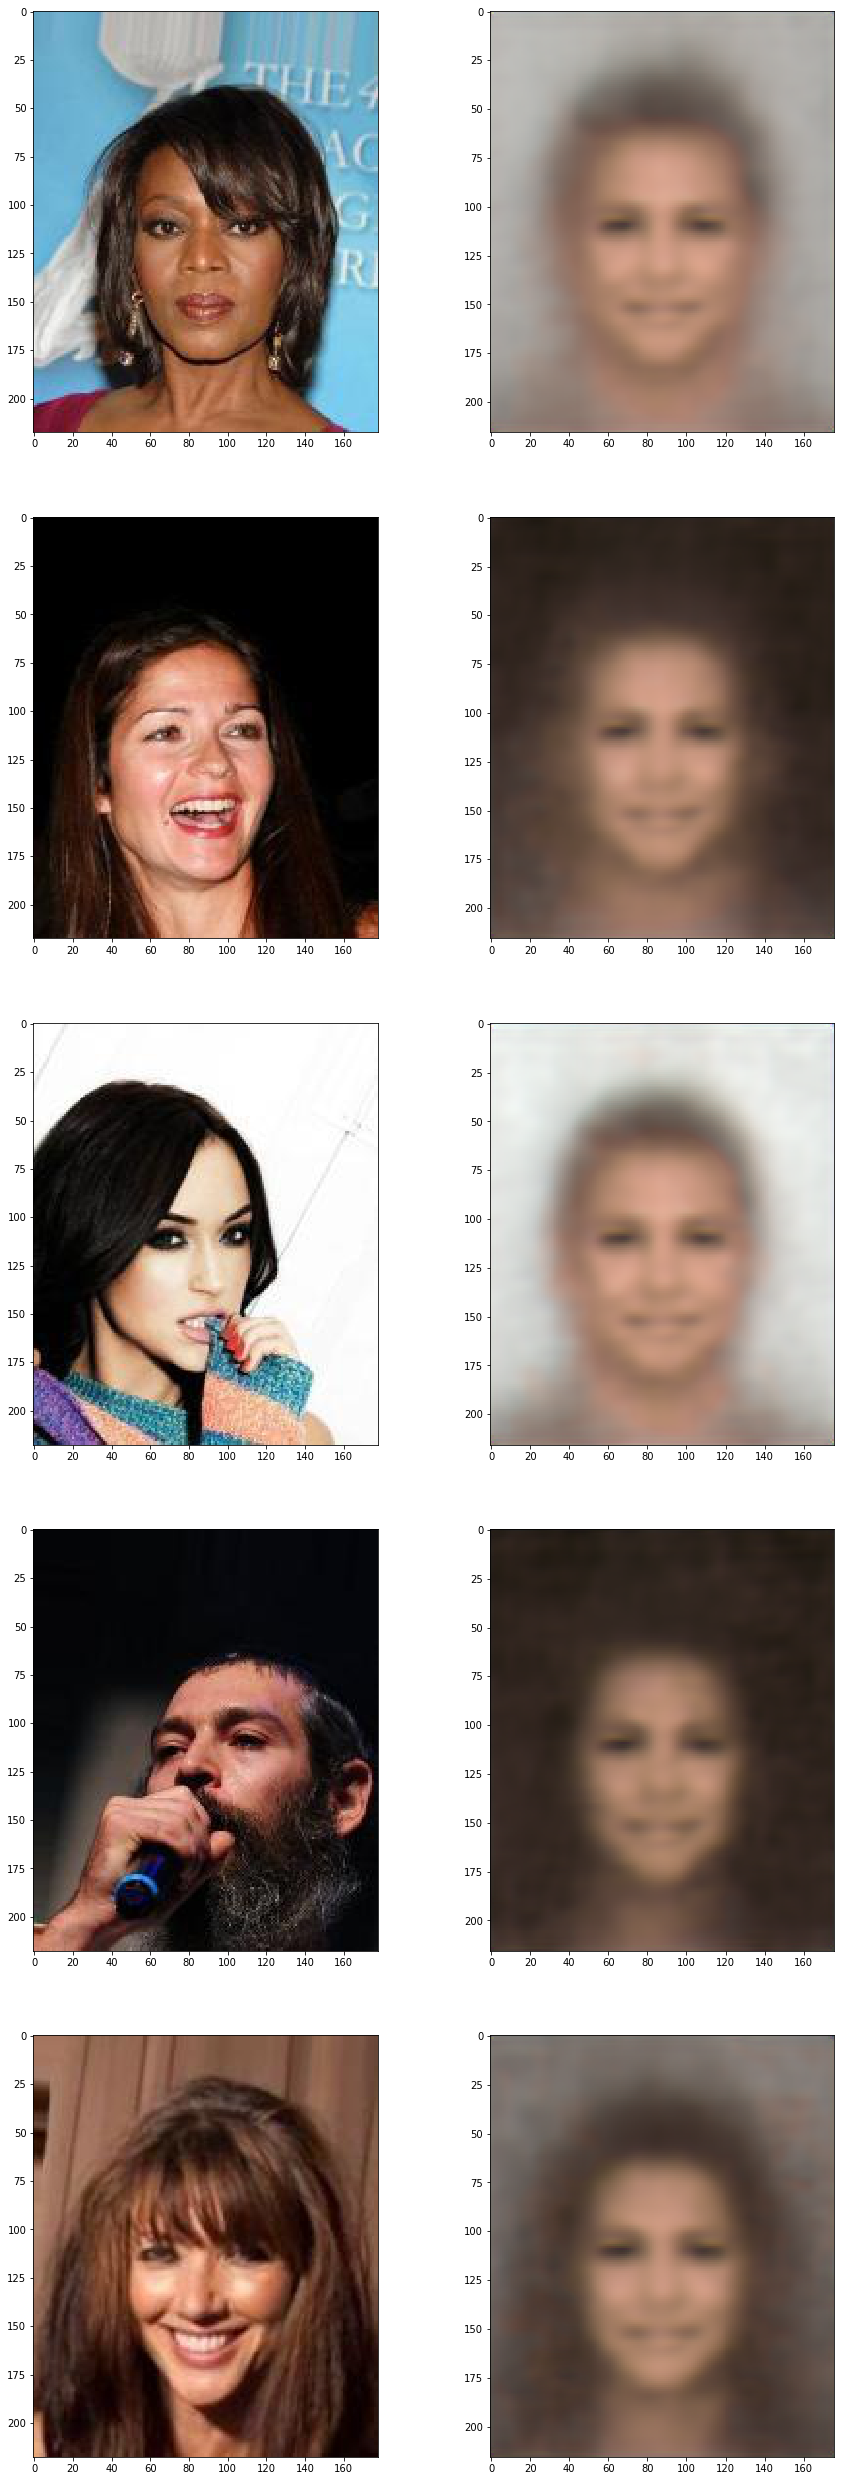

In [145]:
fig, ax = gen_pred_images(model=vae, generator=val_generator, n_images=n_images)

### 1.B.4.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


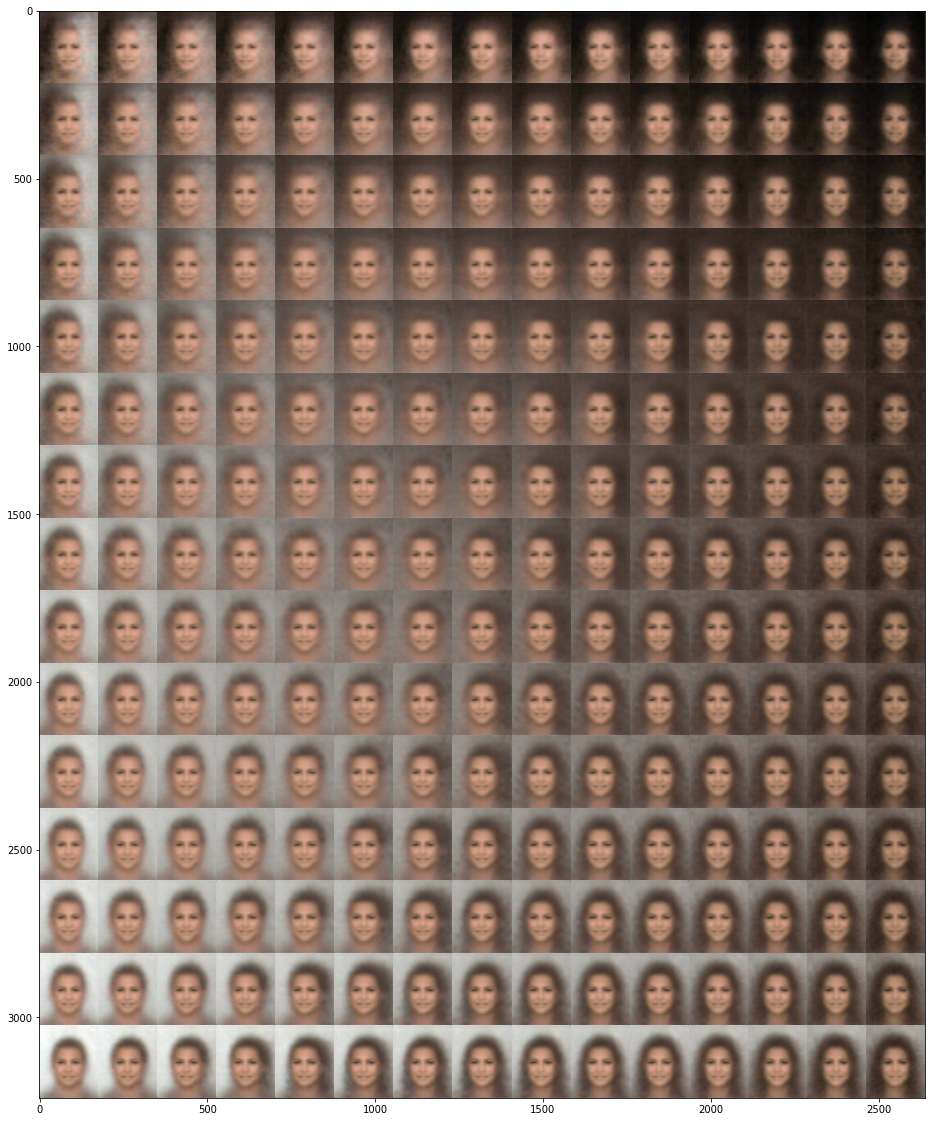

In [146]:
# Display a 2D manifold of the samples

n = 15  # figure with 20x20 samples
height = train_generator.image_shape[0]
width = train_generator.image_shape[1]

figure = np.zeros((height * n, width * n, 3))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #z_sample = pred_enc[0].copy()
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(x=z_sample)
        sample = x_decoded[0]
        figure[i * height: (i + 1) * height,j * width: (j + 1) * width] = sample

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()  

### 1.B.5.

### Part C: Building and Training a DCGAN Model [43 pts]

**1.C.1.** Create and compile a DCGAN model for the celebrity faces dataset.  Print summaries for the discriminator and generator models.

**1.C.2.** Train your model on the images in the celeba dataset.

**1.C.3.** Generate and visualise around 15 celebrity faces.  How do the generated faces compare in quality to celebrity faces from the training samples? How do they compare in quality to the faces generated via VAE?

#### Please note that the DCGAN model can take a long time to train before you obtain good results. Expect to train for more than 2 hrs depending on the batch size and number of epochs

## Solution: Part C

In [158]:
SPATIAL_DIM = 32 # Spatial dimensions of the images.
LATENT_DIM = 100 # Dimensionality of the noise vector.
BATCH_SIZE = 32 # Batchsize to use for training.
DISC_UPDATES = 1  # Number of discriminator updates per training iteration.
GEN_UPDATES = 1 # Nmber of generator updates per training iteration.

FILTER_SIZE = 5 # Filter size to be applied throughout all convolutional layers.
NUM_LOAD = 10000 # Number of images to load from CelebA. Fit also according to the available memory on your machine.
NET_CAPACITY = 16 # General factor to globally change the number of convolutional filters.

PROGRESS_INTERVAL = 80 # Number of iterations after which current samples will be plotted.
ROOT_DIR = 'visualization' # Directory where generated samples should be saved to.

if not os.path.isdir(ROOT_DIR):
    os.mkdir(ROOT_DIR)

In [159]:
faces = glob.glob('data/img_align_celeba/*.jpg')
faces[0]

'data/img_align_celeba/116549.jpg'

In [160]:
X = []
# Reference to CelebA dataset here.
faces = glob.glob('data/img_align_celeba/*.jpg')

for i, f in enumerate(faces):
    img = cv2.imread(f)
    img = img_preprocess(img, (SPATIAL_DIM,SPATIAL_DIM))
    X.append(img[0])
    if i >= NUM_LOAD - 1:
        break
X = np.array(X)

(10000, 32, 32, 3)

((10000, 32, 32, 3), 0.0, 1.0)

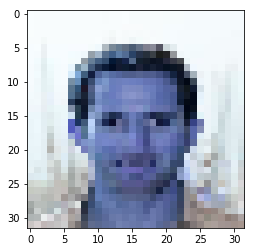

In [161]:
display(X.shape)
plt.imshow(X[5])
X.shape, X.min(), X.max()

### 1.C.1.

In [46]:
#@title
z_dim = 100
adam = Adam(lr=0.0002, beta_1=0.5)


#GENERATOR
g = Sequential()
g.add(Dense(input_dim=z_dim, output_dim=1024))
g.add(Activation('tanh'))
g.add(Dense(128*7*7))
g.add(BatchNormalization())
g.add(Activation('tanh'))
g.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
g.add(UpSampling2D(size=(2, 2)))
g.add(Conv2D(64, (5, 5), padding='same'))
g.add(Activation('tanh'))
g.add(UpSampling2D(size=(2, 2)))
g.add(Conv2D(1, (5, 5), padding='same'))
g.add(Activation('tanh'))

#DISCRIMINATOR
d = Sequential()
d.add(
        Conv2D(64, (5, 5),
        padding='same',
        input_shape=(28, 28, 1))
        )
d.add(Activation('tanh'))
d.add(MaxPooling2D(pool_size=(2, 2)))
d.add(Conv2D(128, (5, 5)))
d.add(Activation('tanh'))
d.add(MaxPooling2D(pool_size=(2, 2)))
d.add(Flatten())
d.add(Dense(1024))
d.add(Activation('tanh'))
d.add(Dense(1))
d.add(Activation('sigmoid'))

#GAN
d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

TypeError: The added layer must be an instance of class Layer. Found: Tensor("input_5:0", shape=(?, 218, 178, 3), dtype=float32)

In [ ]:
def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    losses = {"D":[], "G":[]}
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Generate the images from the noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

## Question 2: VAE-GANIME [3 pts - ALMOST OPTIONAL] 

Wikipedia describes [Anime]() as follows:

Anime is hand-drawn and computer animation originating from or associated with Japan.  

The word anime is the Japanese term for animation, which means all forms of animated media. Outside Japan, anime refers specifically to animation from Japan or as a Japanese-disseminated animation style often characterized by colorful graphics, vibrant characters and fantastical themes. The culturally abstract approach to the word's meaning may open up the possibility of anime produced in countries other than Japan For simplicity, many Westerners strictly view anime as a Japanese animation product. Some scholars suggest defining anime as specifically or quintessentially Japanese may be related to a new form of Orientalism

We've provided you a dataset of anime faces and we want you to create a model to generate faces in the same style using a special form of GAN, a VAE-GAN.  The term VAE-GAN was first used by Larsen et. al in their paper [“Autoencoding beyond pixels using a learned similarity metric”](https://arxiv.org/abs/1512.09300).  VAE-GAN models differentiate themselves from GANs in that their generators are variation autoencoders.

![](https://cdn-images-1.medium.com/max/800/0*KEmfTtghsCDu6UTb.png)

### Part A: Preparing the Data 

**2.A.1.** Download the dataset from [Anime-Face Dataset](https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/anime-faces.zip). It contains over 20K anime faces in the form of 64x64 images.  Use them to create your anime face dataset.  Again, you may find it to your advantage to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).

### Part B: Building and Training a DCGAN 

**2.B.1.** Create and compile a DCGAN model for the anime faces dataset.  Print summaries for the generator and discriminator models

**2.B.2.** Train your model on the images in the anime faces dataset.

**2.B.3.** Generate and visualise around 15 anime faces not in your training set.  How do the generated faces compare in quality to anime faces from the training samples?

### Part C: Building and Training a VAE-GAN 

**2.C.1.** Create and compile a VAE-GAN model for the anime faces dataset.  Print summaries for the encoder, decoder and discriminator models

**2.C.2.** Train your model on the images in the anime faces dataset.

**2.C.3.** Generate and visualise around 15 anime faces not in your training set.  How do the generated faces compare in quality to anime faces from the training samples? How do they compare to the faces from the traditional GAN?

#### Please note that the DCGAN model can take a long time to train before you obtain good results. Expect to train for more than 2 hrs depending on the batch size and number of epochs